In [1]:
import pandas as pd
import seaborn as sns #used for data visualisation
import numpy as np
from matplotlib import pyplot as plt
from datetime import timedelta #used timedelta to represent the duration and differences between time and dates.
plt.style.use('seaborn')
%matplotlib inline

# Analysis of Cycling Data

## Required Analysis

1. Removing rides with no measured power (where device_watts is False) - these are commutes or MTB rides
* Looking at the distributions of some key variables: time, distance, average speed, average power, TSS. Finding that did they normally distributed or Skewed? 
* Exploring the relationships between the following variables. Finding out any of them are corrolated with each other (do they vary together in a predictable way)? Explaining about relationships that I observed?  
    * Distance
    * Moving Time
    * Average Speed
    * Heart Rate
    * Power (watts)
    * Normalised power (NP)
    * Training Stress Score
    * Elevation Gain
    
* Some of the rides are designated as "Race" in the `workout_type` field, these are where I am racing and you might expect that these would be the most challenging rides.  Normalised Power (NP) is a good measure of how hard a ride is.  Exploring the values of `NP` for races vs the overall set of rides to see if this hypothesis is supported (using graphs and summary statistics). Finding that are races more challenging than rides in general? 

* It is useful to see a summary of rides over the year. So generating a plot that summarises the number of km ridden each month over the period of the data. Overlaying this with the _sum_ of the Training Stress Score and the _average_ of the Average Speed to generate an overall summary of activity.

Hint: To generate these summary plots I need to use the [timeseries/date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) in Pandas to generate a new data frame containing the required data.  


* Generating another summary graph but one that shows the activity over a given month, with the sum of the values for each day of the month shown.  So, if there are two rides on a given day, the graph should show the sum of the distances etc for these rides.

## Loading Data

The first dataset is an export of my ride data from [Strava](https://strava.com/), an online social 
network site for cycling and other sports.  This data is a log of every ride since the start of 2018
and contains summary data like the distance and average speed.  It was exported using 
the script `scripts/stravaget.py` which uses the stravalib module to read data. Some details of
the fields exported by that script can be seen in [the documentation for stravalib](https://pythonhosted.org/stravalib/api.html#stravalib.model.Activity). 

The exported data is a CSV file so that's easy to read, however the date information in the file is 
recorded in a different timezone (UTC) so I need to do a bit of conversion.  In reading the data I'm
setting the index of the data frame to be the datetime of the ride.

In [2]:
strava = pd.read_csv('data/strava_export.csv', index_col='date', parse_dates=True) #Reading  the csv file
strava.head().T

date,2018-01-02 20:47:51+00:00,2018-01-04 01:36:53+00:00,2018-01-04 02:56:00+00:00,2018-01-04 05:37:04+00:00,2018-01-05 19:22:46+00:00
average_heartrate,100.6,NaN,83.1,110.1,110.9
average_temp,21,24,25,24,20
average_watts,73.8,131.7,13.8,113.6,147.7
device_watts,False,False,False,False,True
distance,15.2,18,0,22.9,58.4
elapsed_time,94,52,3,77,189
elevation_gain,316.00 m,236.00 m,0.00 m,246.00 m,676.00 m
kudos,10,5,2,8,12
moving_time,73,46,2,64,144
workout_type,Ride,Ride,Ride,Ride,Ride


The second dataset comes from an application called [GoldenCheetah](https://www.goldencheetah.org/) which provides
some analytics services over ride data.  This has some of the same fields but adds a lot of analysis of the 
power, speed and heart rate data in each ride.  This data overlaps with the Strava data but doesn't include all 
of the same rides. 

Again I create an index using the datetime for each ride, this time combining two columns in the data (date and time) 
and localising to Sydney so that the times match those for the Strava data. 

In [3]:
cheetah = pd.read_csv('data/cheetah.csv', skipinitialspace=True)
cheetah.index = pd.to_datetime(cheetah['date'] + ' ' + cheetah['time']) #Changing the date&time format
cheetah.index = cheetah.index.tz_localize('Australia/Sydney')
cheetah.head().T

,2018-01-28 06:39:49+11:00,2018-01-28 07:01:32+11:00,2018-02-01 08:13:34+11:00,2018-02-06 08:06:42+11:00,2018-02-07 17:59:05+11:00
date,01/28/18,01/28/18,02/01/18,02/06/18,02/07/18
time,06:39:49,07:01:32,08:13:34,08:06:42,17:59:05
filename,2018_01_28_06_39_49.json,2018_01_28_07_01_32.json,2018_02_01_08_13_34.json,2018_02_06_08_06_42.json,2018_02_07_17_59_05.json
axPower,202.211,226.039,0,221.672,218.211
aPower Relative Intensity,0.75452,0.84343,0,0.82714,0.81422
...,...,...,...,...,...
Rest HF,0,0,0,0,0
HRV Recovery Points,0,0,0,0,0
NP,222.856,245.365,0,253.702,232.644
IF,0.83155,0.91554,0,0.94665,0.86808


The GoldenCheetah data contains many variables (columns) and I won't go into all of them here. Some
that are of particular interest for the analysis below are:

Here are definitions of some of the more important fields in the data. Capitalised fields come from the GoldenCheetah data
while lowercase_fields come from Strava. There are many cases where fields are duplicated and in this case the values
should be the same, although there is room for variation as the algorithm used to calculate them could be different
in each case. 

  * Duration - overall duration of the ride, should be same as elapsed_time
  * Time Moving - time spent moving (not resting or waiting at lights), should be the same as moving_time
  * Elevation Gain - metres climbed over the ride
  * Average Speed - over the ride
  * Average Power - average power in watts as measured by a power meter, relates to how much effort is being put in to the ride, should be the same as  * average_watts' from Strava
  * Nonzero Average Power - same as Average Power but excludes times when power is zero from the average
  * Average Heart Rate - should be the same as average_heartrate
  * Average Cadence - cadence is the rotations per minute of the pedals
  * Average Temp - temperature in the environment as measured by the bike computer (should be same as average_temp)
  * VAM - average ascent speed - speed up hills
  * Calories (HR) - Calorie expendature as estimated from heart rate data
  * 1 sec Peak Power - this and other  'Peak Power' measures give the maximum power output in the ride over this time period.  Will be higher for shorter periods. High values in short periods would come from a very 'punchy' ride with sprints for example.
  * 1 min Peak Hr - a similar measure relating to Heart Rate
  * NP - Normalised Power, a smoothed average power measurement, generally higher than Average Power 
  * TSS - Training Stress Score, a measure of how hard a ride this was
  * device_watts - True if the power (watts) measures were from a power meter, False if they were estimated
  * distance - distance travelled in Km
  * kudos - likes from other Strava users (social network)
  * workout_type - one of  'Race',  'Workout' or  'Ride'
  
  
Some of the GoldenCheetah parameters are defined [in thier documentation](https://github.com/GoldenCheetah/GoldenCheetah/wiki/UG_Glossary).  

## My Tasks

Here the task is to combine these two data frames using the [`join` method of Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#joining-on-index). The goal is to keep only those rows of data 
that appear in __both__ data frames so that I have complete data for every row.  

In [4]:
df = pd.merge(left = cheetah, right = strava, left_index = True, right_index= True, how = 'inner')

In [5]:
df.head().T

,2018-01-27 19:39:49+00:00,2018-01-27 20:01:32+00:00,2018-01-31 21:13:34+00:00,2018-02-05 21:06:42+00:00,2018-02-07 06:59:05+00:00
date,01/28/18,01/28/18,02/01/18,02/06/18,02/07/18
time,06:39:49,07:01:32,08:13:34,08:06:42,17:59:05
filename,2018_01_28_06_39_49.json,2018_01_28_07_01_32.json,2018_02_01_08_13_34.json,2018_02_06_08_06_42.json,2018_02_07_17_59_05.json
axPower,202.211,226.039,0,221.672,218.211
aPower Relative Intensity,0.75452,0.84343,0,0.82714,0.81422
...,...,...,...,...,...
elapsed_time,17,67,649,69,144
elevation_gain,95.00 m,449.00 m,612.00 m,439.00 m,890.00 m
kudos,4,19,6,6,10
moving_time,17,67,113,65,134


## 1. Removing rides with no measured power (where device_watts is False) - these are commutes or MTB rides

In [6]:
#removing rides with device_watts is false
df = df[df.device_watts != False]

## 2. Looking at the distributions of some key variables: time, distance, average speed, average power, TSS and finding out  whether they  are normally distributed or Skewed.

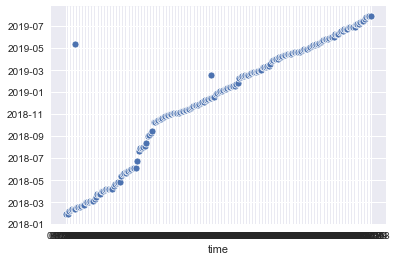

In [8]:
#using scatterplot to know the distribution of time
sns.scatterplot(df.time,df.index)

### The plot for time and index which is date showing us it is normally distributed because it is following a straight line excluding the outliers.

0.639848956755223

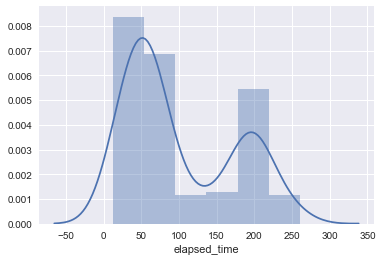

In [9]:
sns.distplot(df.elapsed_time)
df.elapsed_time.skew()

### The plot for the elapsed_time is showing us a positive skewness, so it is skewed right.

0.5551058851589188

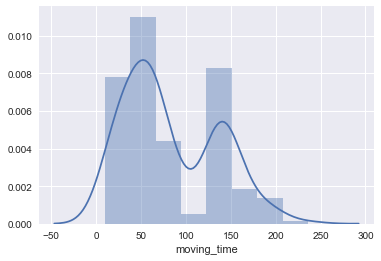

In [10]:
sns.distplot(df.moving_time)
df.moving_time.skew()

### The plot for the moving_time is showing us a positive skewness, so it is skewed right.

0.5198700561050731

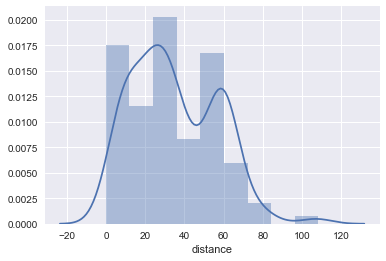

In [11]:
sns.distplot(df.distance)
df.distance.skew()

### The plot for the distance is showing us a positive skewness, so it is skewed right.

-0.8383509023831505

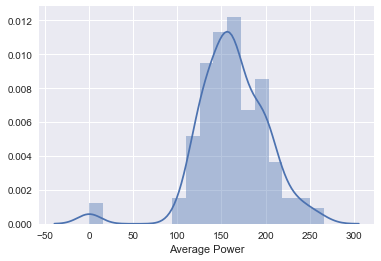

In [12]:
sns.distplot(df["Average Power"])
df["Average Power"].skew()

### The plot for the Average power is showing us a negative skewness, so it is skewed left.

-0.9239180485603232

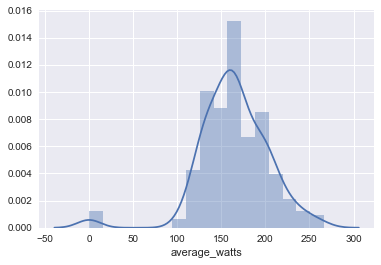

In [13]:
sns.distplot(df["average_watts"].fillna(0))
(df["average_watts"].fillna(0)).skew()

### The plot for the average_watts is showing us a negative skewness, so it is skewed left.

1.055780702424325

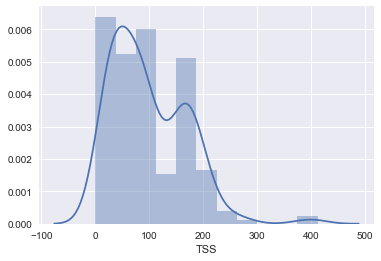

In [14]:
sns.distplot(df.TSS)
df.TSS.skew()

### The plot for the TSS is showing us a positive skewness, so it is skewed right.

## 3. Exploring the relationships between the following variables. Finding that any of them are corrolated with each other (do they vary together in a predictable way) and explaining about the relationships I observe.

### Distance
### Moving Time
### Average Speed
### Heart Rate
### Power (watts)
### Normalised power (NP)
### Training Stress Score
### Elevation Gain

### Taking the variables to find the relationship and creating a new dataframe with those variables.

In [15]:
df1 = df[["distance","moving_time","Average Speed","average_heartrate","Average Power","NP","TSS","Elevation Gain"]]

### We can find the correlation using the function corr(). We can interpret the relationships from the correlation matrix. we can say, one variable increases(+) then positive correlation, one variable decreases(-) then negative correlation, no correlation when zero(0) and had no association with the other variable.

In [16]:
correlation = df1.corr()
correlation

,distance,moving_time,Average Speed,average_heartrate,Average Power,NP,TSS,Elevation Gain
distance,1.000000,0.939383,0.187363,0.114595,0.129199,0.270703,0.922565,0.805468
moving_time,0.939383,1.000000,-0.103484,-0.048611,-0.109838,0.044431,0.871368,0.813146
Average Speed,0.187363,-0.103484,1.000000,0.742388,0.814403,0.674857,0.134054,-0.016160
average_heartrate,0.114595,-0.048611,0.742388,1.000000,0.692413,0.593091,0.113775,0.071553
Average Power,0.129199,-0.109838,0.814403,0.692413,1.000000,0.844487,0.225290,-0.035987
NP,0.270703,0.044431,0.674857,0.593091,0.844487,1.000000,0.432286,0.229933
TSS,0.922565,0.871368,0.134054,0.113775,0.225290,0.432286,1.000000,0.828928
Elevation Gain,0.805468,0.813146,-0.016160,0.071553,-0.035987,0.229933,0.828928,1.000000


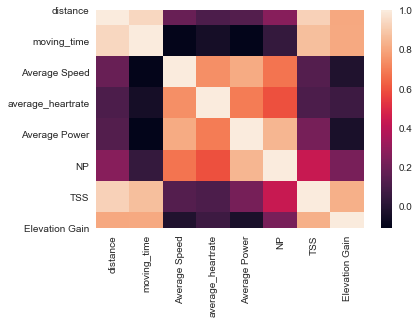

In [17]:
sns.heatmap(correlation)

### From the graph, we can observe that
### distance is higly correlated with moving_time,TSS and Elevation Gain.

### moving_time is highly correlated with distance,TSS and Elevation Gain.

### Average Speed is highly correlated with average_heartrate,Average Power and NP.

### average_heartrate is highly correlated with Average Speed,Average Power and NP.

### Average Power is highly correlated with Average Speed,average_heartrate and NP.

### NP is highly correlated with Average Speed,average_heartrate and Average Power.

### TSS is highly correlated with distance,moving_time and Elevation Gain.

### Elevation Gain os highly correlated with distance,moving_time and TSS.

## 4. Some of the rides are designated as "Race" in the workout_type field, these are where I am racing and you might expect that these would be the most challenging rides. Normalised Power (NP) is a good measure of how hard a ride is. Exploring the values of NP for races vs the overall set of rides to see if this hypothesis is supported (use graphs and summary statistics). Finding that are races more challenging than rides in general.

### Creating a dataframe as workout with the variables NP and workout_type. Using seaborn library as sns to countplot the workout_type

In [18]:
workout = df[["NP","workout_type"]]

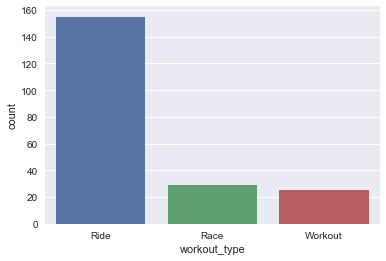

In [19]:
sns.countplot(x = "workout_type", data = workout)

### Using boxplot to know the normalised power is higher in race when compared to the other

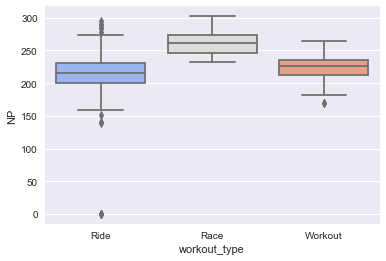

In [20]:
sns.boxplot(x='workout_type', y='NP', data=workout, palette='coolwarm')

By obseving the above boxplot, we can say that Races are more challenging than Rides. Normalised power is higher in race compared to ride.

## 5. It is useful to see a summary of rides over the year. Generating a plot that summarises the number of km ridden each month over the period of the data. Overlaying this with the sum of the Training Stress Score and the average of the Average Speed to generate an overall summary of activity.

In [21]:
df2 = pd.DataFrame()
df2["distance"] = df["distance"]
df2["date"] = df["date"]
# converting date format
df2['date'] = pd.to_datetime(df2['date']) 
# setting date as index
df2 = df2.set_index('date')
# Adding distance for monthly and grouping
df2 = df2.groupby(pd.Grouper(freq = 'M')).sum()

### Plotting the kms ridden each month by creating a new dataframe with distance and date variables and by grouping the daily data into monthly using groupby() function.

<Figure size 432x288 with 0 Axes>

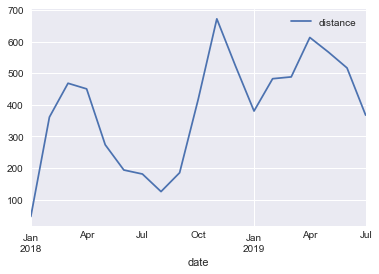

In [22]:
plt.figure()
df2.plot()
plt.show()

Distance(Kms) ridden each month over the period of the data and it is clearly showing that, there is a huge increase in the month of november.

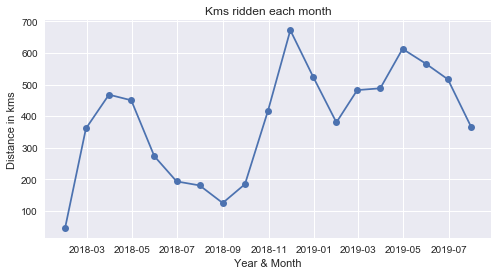

In [23]:
plt.figure(figsize = (8,4))
# using matplotlib pyplot as plt
plt.title("Kms ridden each month")
plt.xlabel("Year & Month")
plt.ylabel("Distance in kms")
plt.plot(df2,marker = 'o')
plt.show()

### Plotting the graph for TSS

In [24]:
df3 = pd.DataFrame() #creating dataframe
df3["TSS"] = df.TSS
df3["date"] = df.date
df3["date"] = pd.to_datetime(df3["date"]) #converting date format
df3 = df3.set_index('date') #setting date as index
df3 = df3.groupby(pd.Grouper(freq = 'M')).sum() #grouping month and adding

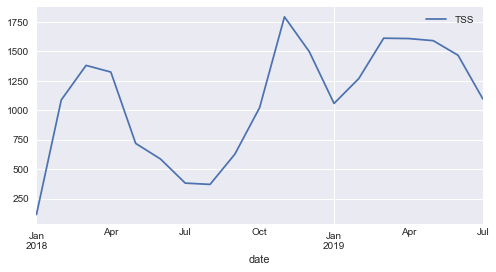

In [25]:
df3.plot(figsize = (8,4))

By observing the above graph, there is an increase of Training stress score in november which shows that the rides are harder in november.

## Plotting the graph for Average Speed

In [26]:
#creating dataframe
df4 = pd.DataFrame()
df4["Average Speed"] = df["Average Speed"]
df4["date"] = df.date
# converting date format
df4["date"] = pd.to_datetime(df4["date"])
# setting index as date
df4 = df4.set_index("date")
# grouping month and average of Average Speed
df4 = df4.groupby(pd.Grouper(freq = 'M')).mean()

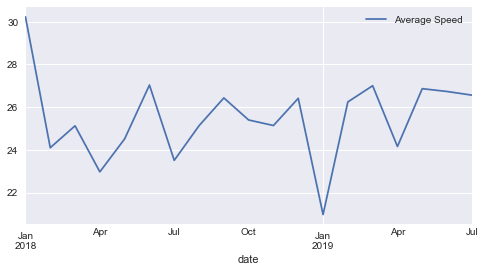

In [27]:
df4.plot(figsize = (8,4))

By observing the above graph, we can say that the average speed has decreased in january.

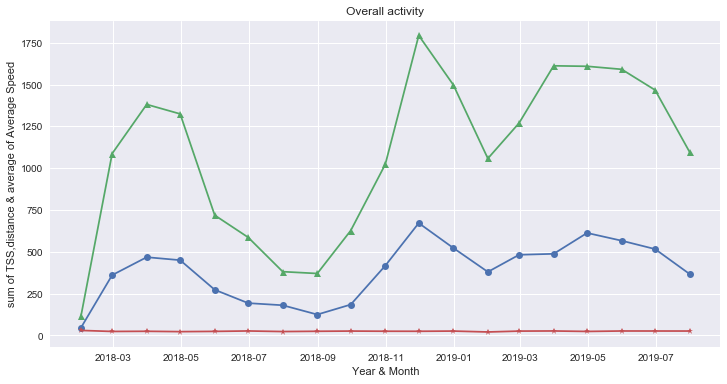

In [28]:
# matplotlib pylot as plt
plt.figure(figsize = (12,6))
plt.title("Overall activity")
plt.xlabel("Year & Month")
plt.ylabel("sum of TSS,distance & average of Average Speed")
plt.plot(df2,marker = "o")
plt.plot(df3,marker = "^")
plt.plot(df4,marker = "*")
plt.show()

## creating a new dataframe with distance, TSS and Average Speed to produce an overlaying graph.

In [29]:
df5 = pd.DataFrame()
df5["distance"] = df2.distance
df5["TSS"] = df3.TSS
df5["Average Speed"] = df4["Average Speed"]

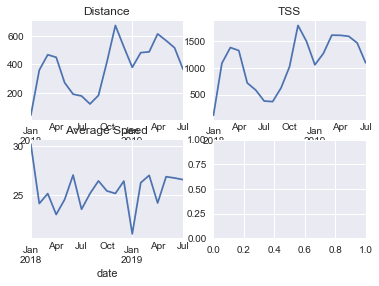

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2)
df2['distance'].plot(ax=axes[0,0]); axes[0,0].set_title('Distance')
df3['TSS'].plot(ax=axes[0,1]); axes[0,1].set_title('TSS')
df4['Average Speed'].plot(ax=axes[1,0]); axes[1,0].set_title('Average Speed')
plt.show()

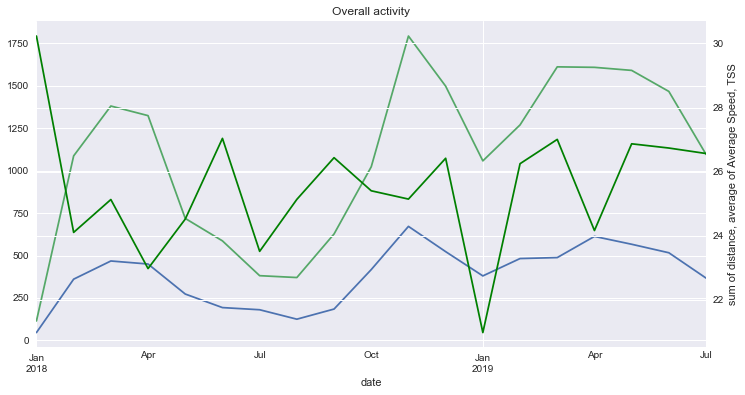

In [31]:
plt.figure(figsize = (12,6))
df5.distance.plot()
df5["Average Speed"].plot(secondary_y=True, style='g')
plt.title("Overall activity")
plt.xlabel("Year & Month")
plt.ylabel("sum of distance, average of Average Speed, TSS")
df5.TSS.plot()

By observing  the above graph, we can say that the overall activity has increased in november and decreased in january for the distance, average speed and traing stress score. The training stress score and distance graphs are in similar shape and both looks like proportional to each other.